In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()

import matplotlib.pyplot as plt
import numpy as np
import jax
import scipy.stats
from jax.scipy.special import expit, logit

import imprint as ip
import confirm.adagrid as ada

In [2]:
def closed_test_full(pvalues, alpha):
    # initialize rejections to false,
    # will have shape = (#criticalvalues, #hypotheses, #gridpoints, #sims)
    temp = pvalues[None, :, :, :] + alpha[:, None, :, :]
    # temp.shape is (10, 3, 360, 100)
    rejected = np.full_like(temp, False)
    # alpha.shape is 10, 360, 100
    epsilon = 1e-10
    for i in range(pvalues.shape[0]):
        sumrejections = np.sum(rejected, axis=1)
        curr_thresh = alpha / (epsilon + pvalues.shape[0] - sumrejections)
        rejected = np.less_equal(pvalues[None, :, :, :], curr_thresh[:, None, :, :])
    return rejected

In [3]:
class BinomialClosed:
    def __init__(self, seed, max_K, *, n):
        self.family = "binomial"
        self.family_params = {"n": n}
        self.n = n

        keys = jax.random.split(jax.random.PRNGKey(seed), num=2)
        self.samples_arm0 = jax.random.uniform(
            keys[0], shape=(max_K, n[0]), dtype=np.float32
        )
        self.samples_arm1 = jax.random.uniform(
            keys[1], shape=(max_K, n[1]), dtype=np.float32
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        p = expit(theta)

        # add up the number of treatment successes for each of the simulations
        # successes is a 2-dimensional array of shape: (n_tiles, n_sims = K)
        successes0 = np.sum(
            self.samples_arm0[None, begin_sim:end_sim, :] < p[:, None, None, 0], axis=2
        )
        successes1 = np.sum(
            self.samples_arm1[None, begin_sim:end_sim, :] < p[:, None, None, 1], axis=2
        )
        
        phat0 = successes0 / self.n[0]
        phat1 = successes1 / self.n[1]
        # pooledphat = (phat1*self.n[1] + phat0*self.n[0]) / (self.n[1] + self.n[0])
        zstat0 = (phat0 - 0.5) / np.sqrt(phat0 * (1 - phat0) / self.n[0])
        zstat1 = (phat1 - 0.7) / np.sqrt(phat1 * (1 - phat1) / self.n[1])
        zstatcombo = (0.4 * (phat0 - 0.5) + 0.6 * (phat1 - 0.7)) / np.sqrt(
            0.4**2 * phat0 * (1 - phat0) / self.n[0]
            + 0.6**2 * phat1 * (1 - phat1) / self.n[1]
        )

        # calculate pvalues for each of the 3 tests
        pvalues = 1 - scipy.stats.norm.cdf([zstat0, zstat1, zstatcombo])

        # when phat0 or phat1 is 0 or 1, we get nan pvalues. this line:
        # 1) when phat is 0, replaces the nans with 1
        # 2) when phat is 1, replaces the nans with 0
        pvalues = np.nan_to_num(pvalues) + (
            [phat0, phat1, phat1 * phat0] == np.full_like(pvalues, 0)
        )
        
        # we're going to check 
        possible_critical_values = np.sort(
            np.concatenate(
                (
                    pvalues,
                    2 * pvalues,
                    3 * pvalues,
                    np.full_like(pvalues[1, :, :], 100)[None, :, :],
                )
            ),
            axis=0,
        )
        # next we need to apply closed testing to the 3 pvalues for EVERY choice in the list of possible critical values
        rejections_list = closed_test_full(pvalues, possible_critical_values)
        nullstatus = np.asarray(np.transpose(null_truth))
        falserejs = np.logical_and(rejections_list, nullstatus[None, :, :, None])
        fwer = np.any(falserejs, axis=1)
        # some akwardness to cause the following minimum to give us the right answer
        temp = 1000 * (1 - fwer) + fwer * possible_critical_values
        out = np.min(temp, axis=0)
        # out.shape : n_tiles, n_sims
        return out

In [4]:
@jax.jit
@jax.vmap
def null_curve(theta):
    return -0.4 * expit(theta[0]) - 0.6 * expit(theta[1]) + (0.5 * 0.4 + 0.7 * 0.6)

class CurveNull(ip.grid.NullHypothesis):
    def dist(self, theta):
        return null_curve(theta)

    def side(self, g):
        _, vertices = g.get_theta_and_vertices()
        eps = 1e-15
        d = vertices.shape[-1]
        vertex_dist = jax.vmap(null_curve)(vertices)
        side = np.zeros(vertices.shape[0], dtype=np.int8)
        side[(vertex_dist >= -eps).all(axis=-1)] = 1
        side[(vertex_dist <= eps).all(axis=-1)] = -1
        return side, None

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1600, worker_id=1, t=1675800101, n_bits=18, worker_bits=18) = [4479641612598902784 4479641612598902785 4479641612598902786, ...]:
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.planar_null:HyperPlane has dimension 1 but grid has dimension 2. Padding with zeros.
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=80, worker_id=1, t=1675800102, n_bits=18, worker_bits=18) = [4479641681318379520 4479641681318379521 4479641681318379522, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=126, worker_id=1, t=1675800103, n_bits=18, worker_bits=18) = [4479641750037856256 4479641750037856257 4479641750037856258, ...]:


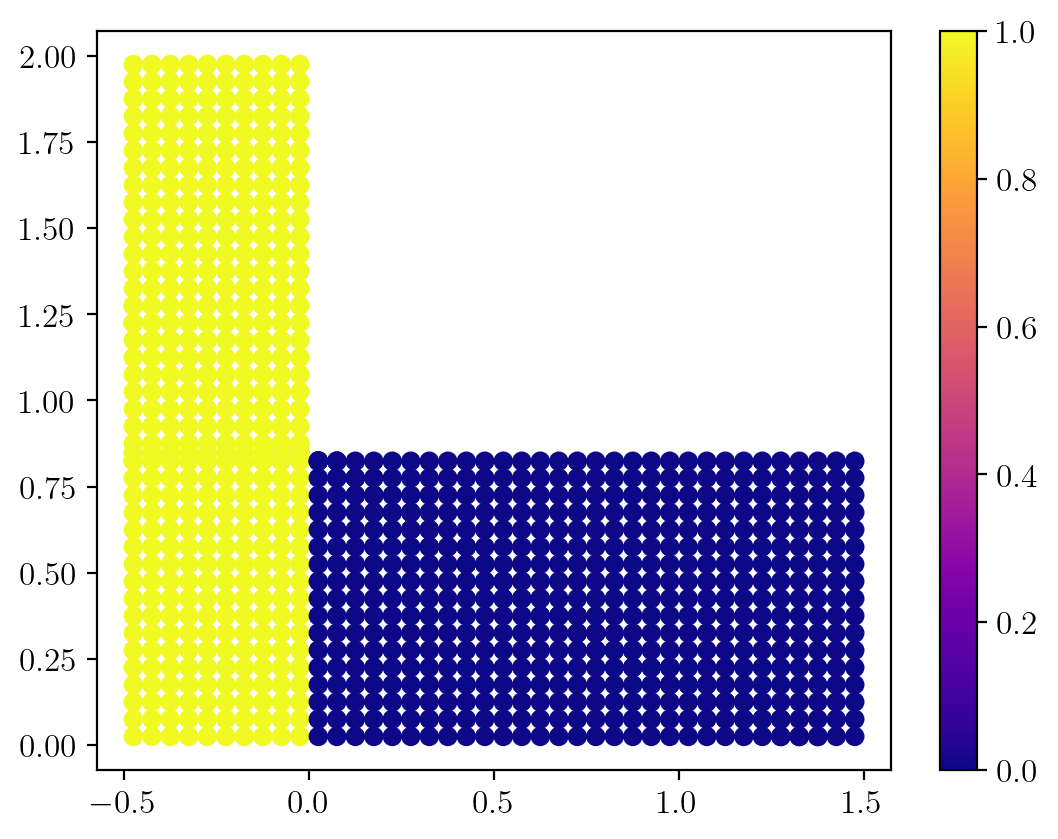

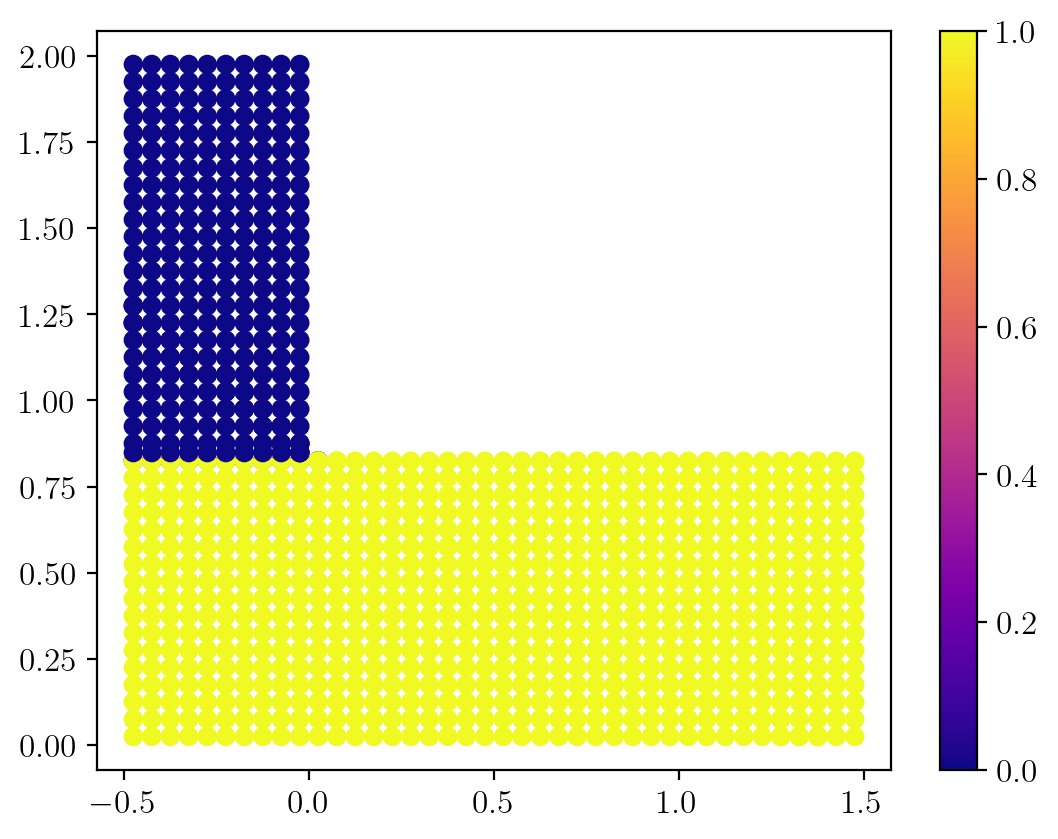

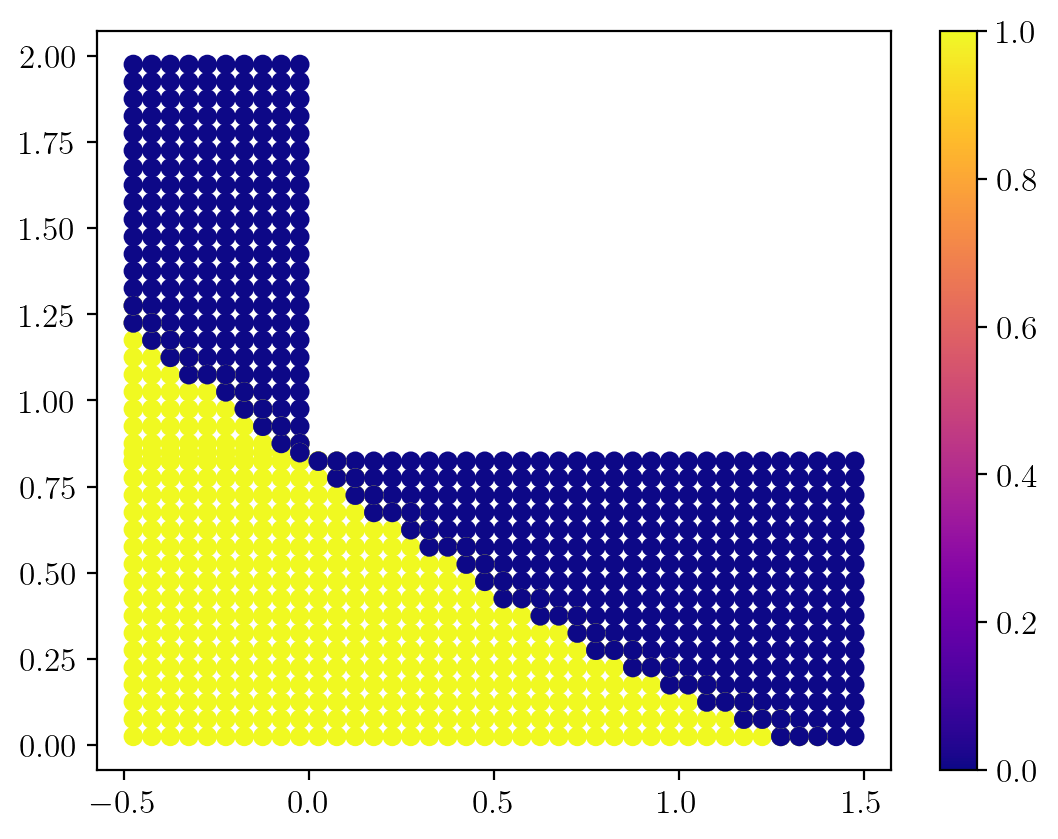

In [5]:
grid = ip.cartesian_grid(
    [-0.5, 0],
    [1.5, 2],
    n=[40, 40],
    prune=True,
    null_hypos=[
        ip.hypo("theta0 < " + str(logit(0.5))),
        ip.hypo("theta1 <" + str(logit(0.7))),
        CurveNull()
    ]
)
plt.scatter(grid.df['theta0'], grid.df['theta1'], c=grid.df['null_truth0'])
plt.colorbar()
plt.show()
plt.scatter(grid.df['theta0'], grid.df['theta1'], c=grid.df['null_truth1'])
plt.colorbar()
plt.show()
plt.scatter(grid.df['theta0'], grid.df['theta1'], c=grid.df['null_truth2'])
plt.colorbar()
plt.show()

In [6]:
val_df = ip.validate(
    BinomialClosed, g=grid, lam=0.025, K=10000, model_kwargs=dict(n=np.array([100, 100]))
)

In [7]:
val_df.shape

(1057, 5)

In [8]:
grid.n_tiles, grid.active().n_tiles

(1057, 983)

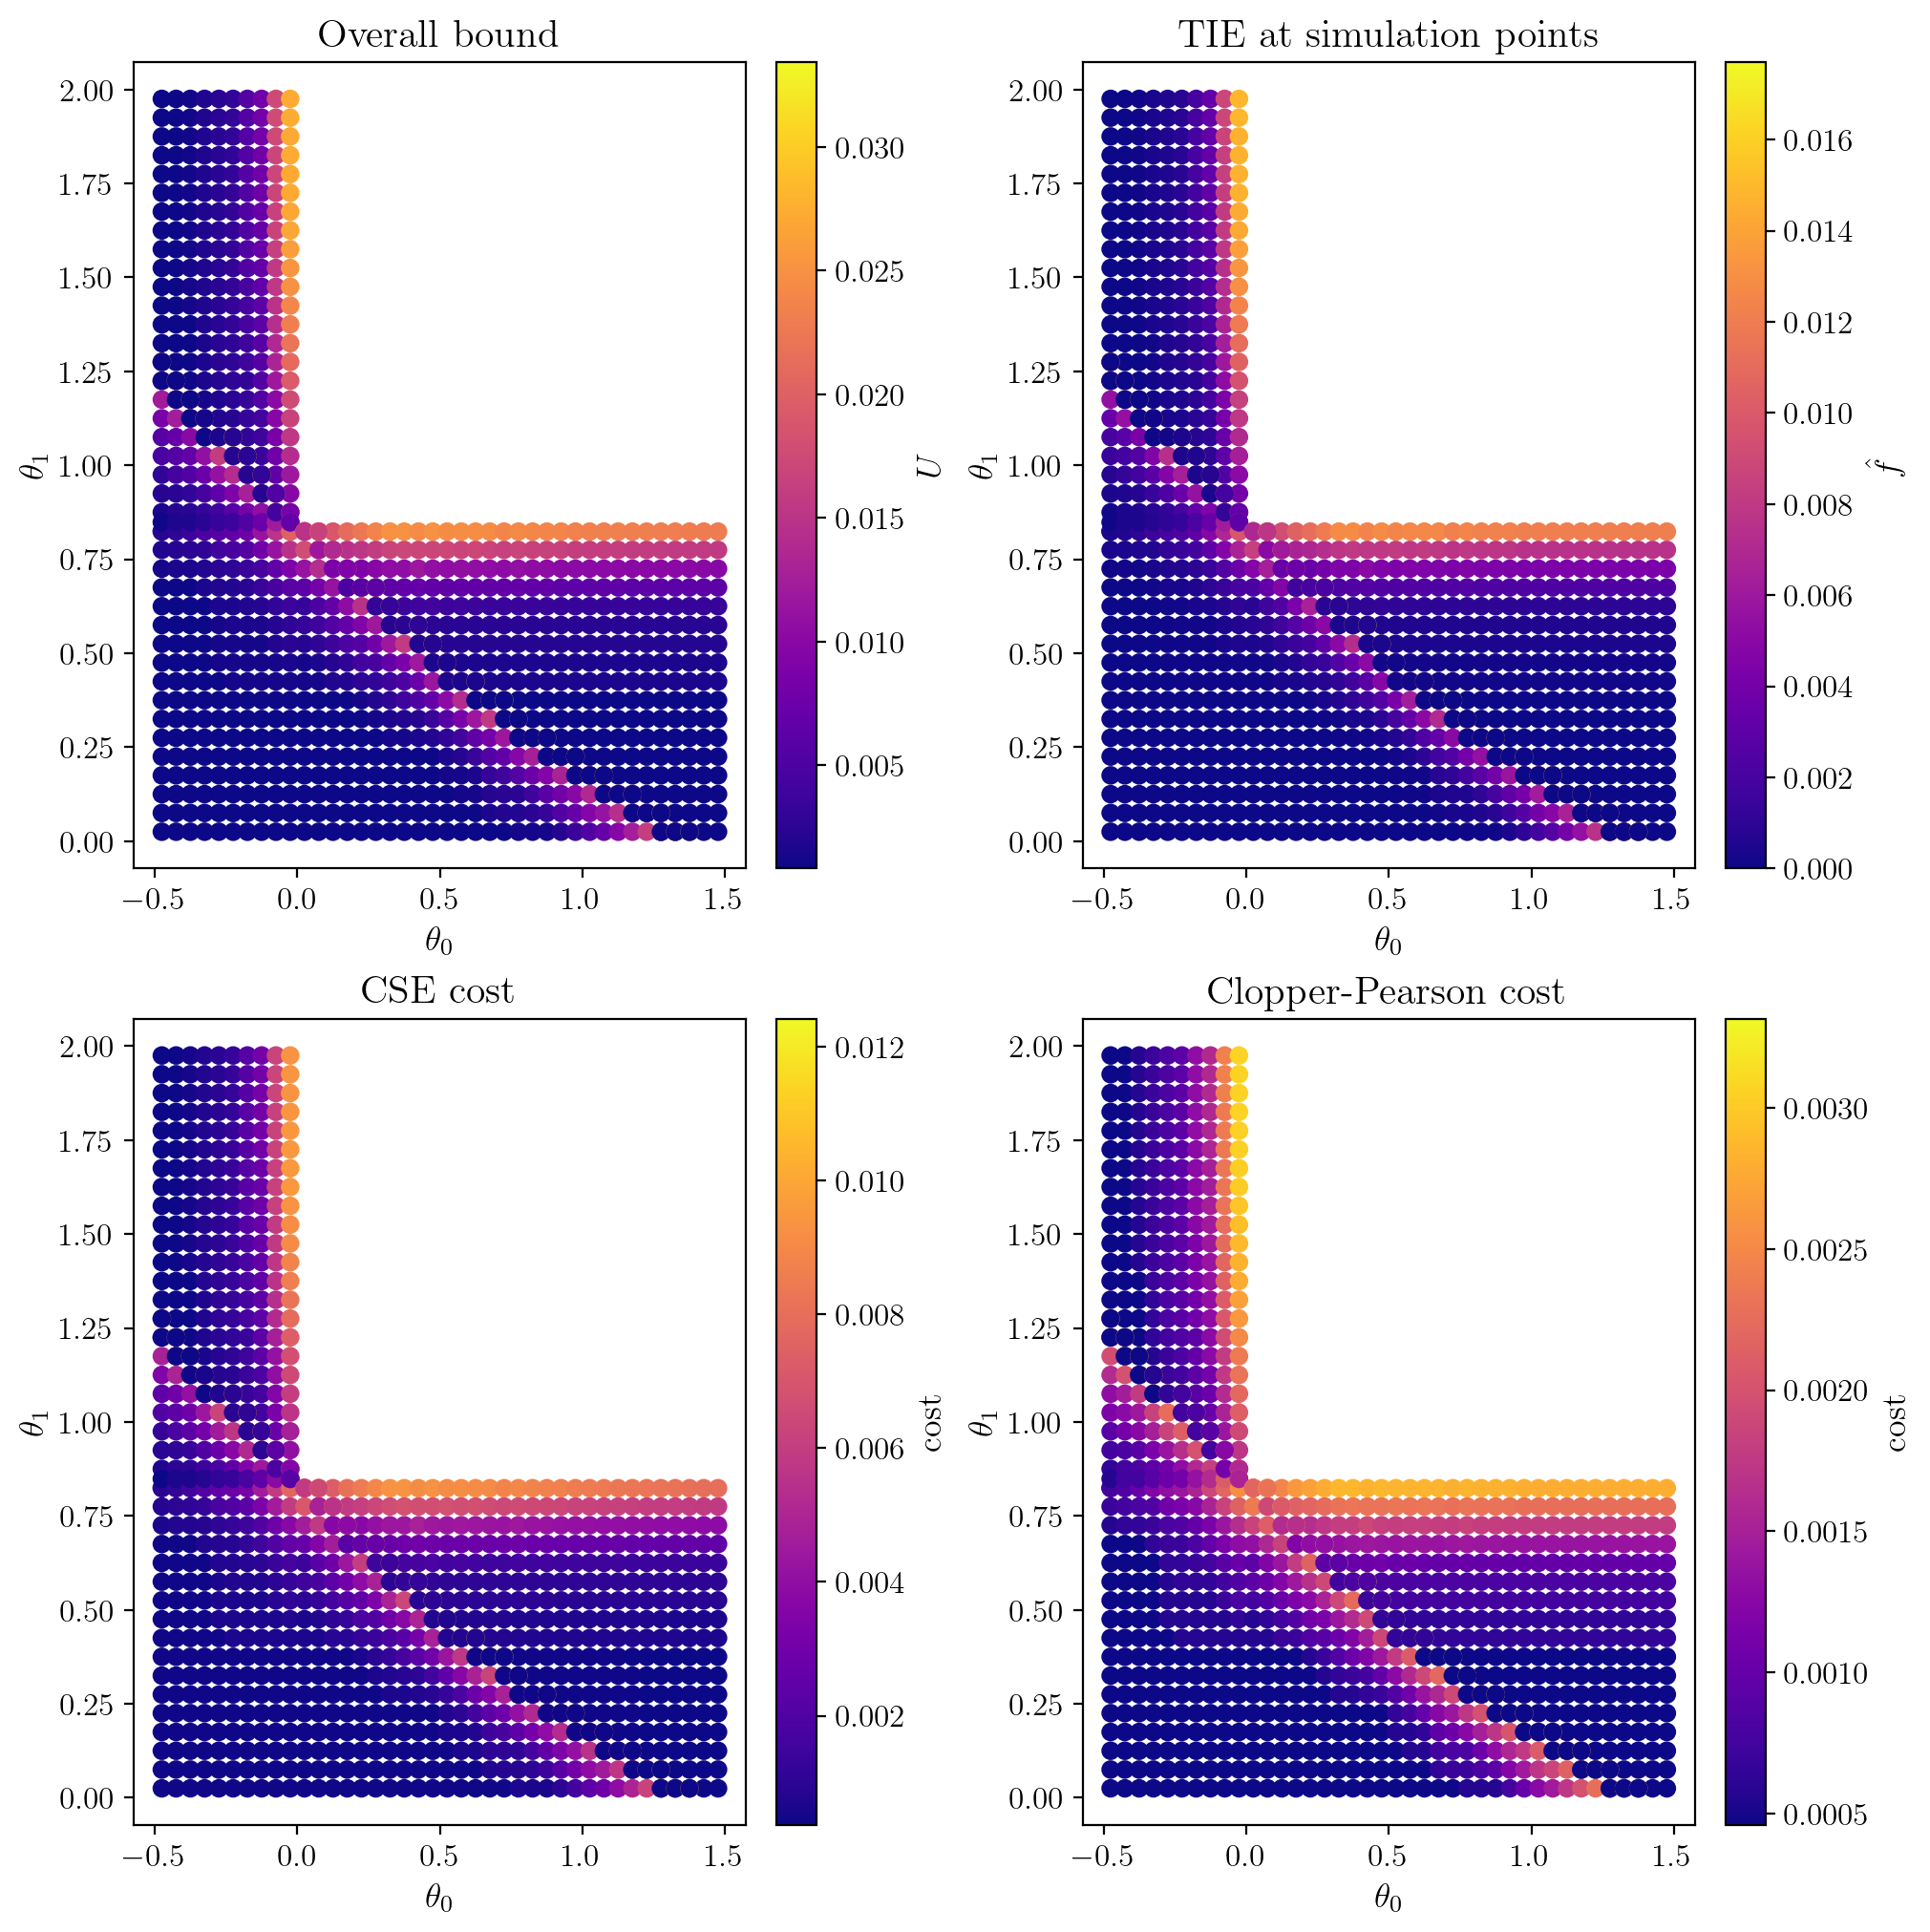

In [9]:
all_null = np.ones(grid.n_tiles, dtype=bool)#grid.df['null_truth2']# & grid.df['null_truth1']# & grid.df['null_truth0']
ada.summarize_validate(grid.subset(all_null), val_df[all_null])

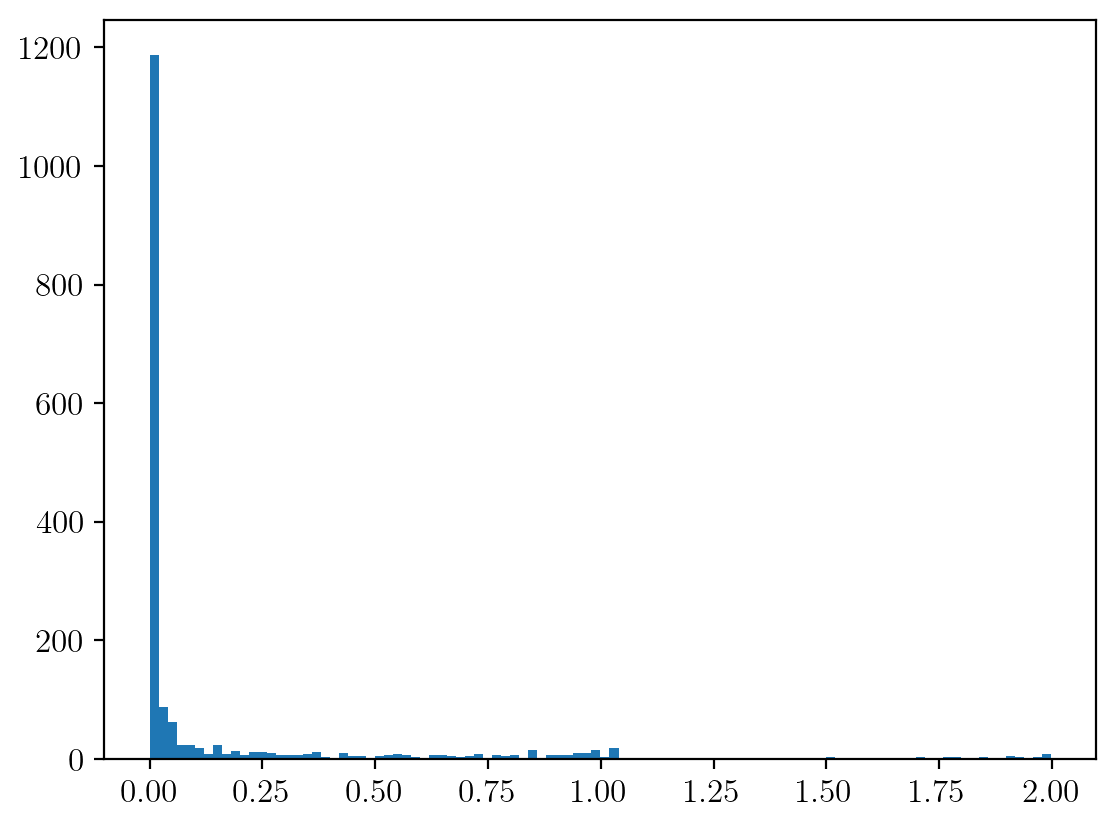

In [13]:
cal_df = ada.bootstrap_calibrate(
    BinomialClosed, g=grid, alpha=0.025, K=20000, model_kwargs=dict(n=np.array([100, 100]))
)
plt.hist(cal_df["lams"], bins=100)
plt.show()


In [21]:
cal_df["lams"].min()


0.02234605

In [22]:
cal_df["idx"]


0      304
1      304
2      304
3      304
4      304
      ... 
955    323
956    323
957    324
958    325
959    326
Name: idx, Length: 960, dtype: int32

In [23]:
cal_df["alpha0"]


0      0.015295
1      0.015281
2      0.015268
3      0.015259
4      0.015251
         ...   
955    0.016201
956    0.016244
957    0.016288
958    0.016332
959    0.016377
Name: alpha0, Length: 960, dtype: float32

[0.023222556, 0.02234605, 0.021091675, 0.024266077, 0.021091675, 0.021091675, 0.023222556, 0.02234605, 0.023222556, 0.021091675, 0.02234605, 0.023700451, 0.024266077, 0.021091675, 0.021091675, 0.024117373, 0.02234605, 0.02234605, 0.025928602, 0.02234605, 0.020139435, 0.02234605, 0.024266077, 0.02234605, 0.02234605, 0.023222556, 0.02234605, 0.02234605, 0.02234605, 0.024266077, 0.02234605, 0.02234605, 0.02234605, 0.021091675, 0.020613395, 0.024266077, 0.02234605, 0.02234605, 0.020613395, 0.024266077, 0.02234605, 0.021091675, 0.021091675, 0.025928602, 0.021091675, 0.021091675, 0.024266077, 0.02234605, 0.02234605, 0.021091675]


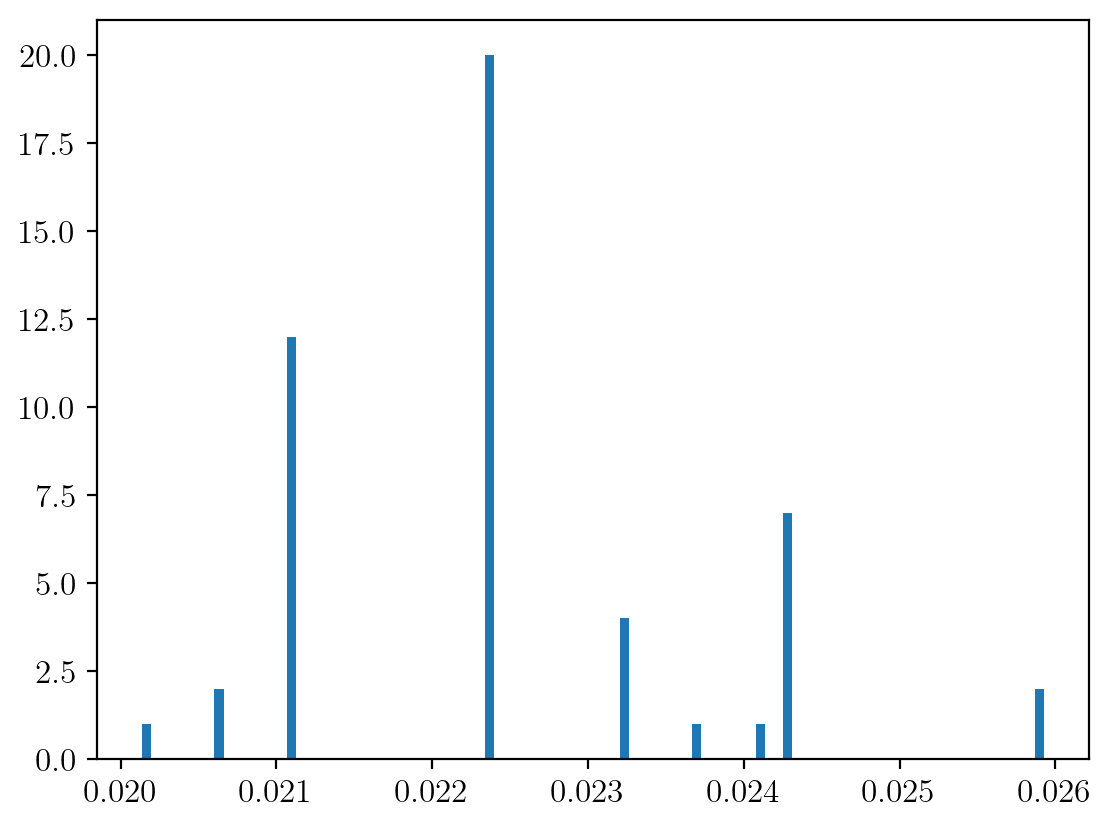

In [24]:
B_lamss = [cal_df[c].min() for c in cal_df.columns if "B_lams" in c]
print(B_lamss)
plt.hist(B_lamss, bins=100)
plt.show()


## Junkyard


In [ ]:
# grid = ip.cartesian_grid(
#        [-3, -3], [3, 3], n=[10, 10], prune=True, null_hypos=[ip.hypo("theta0 < "+str(logit(0.5))), ip.hypo("theta1 <" +str(logit(0.7)))]
# )
# lam = 0.025
# x = expit(grid.df["theta0"] - grid.df["radii0"])*0.4 + 0.6*expit(grid.df["theta1"] - grid.df["radii1"]) < 0.5*0.4 + 0.7*0.6
# grid.df["null_truth2"] = x
# type(grid.df)
# plt.scatter(grid.df["theta0"], grid.df["theta1"], c = grid.df["null_truth2"])
# First building a function which operates on a single grid point
def closed_test(pvalues, alpha):
    rejected = [False] * len(pvalues)
    for i in range(len(pvalues)):
        curr_rejections = sum(rejected)
        curr_thresh = alpha / (len(pvalues) - sum(rejected))
        rejected = [
            rejected[i] or pvalues[i] <= curr_thresh for i in range(len(pvalues))
        ]
        if sum(rejected) == len(pvalues):
            break
    return rejected


# Next, we simultaneously operate on all of the grid-points, and return a list of rejections
def closed_test_half(pvalues, alpha):
    # initialize rejections to false, with shape = shape(pvalues)
    rejected = np.full_like(pvalues, False)
    for i in range(pvalues.shape[1]):
        sumrejections = np.sum(rejected, axis=1)
        curr_thresh = alpha / (pvalues.shape[1] - sumrejections)
        rejected = rejected or pvalues <= curr_thresh[:, None]
        print(rejected)
    return rejected


In [ ]:
grid = ip.cartesian_grid(
    [-0.5, 0],
    [1.5, 2],
    n=[20, 20],
    prune=True,
    null_hypos=[
        ip.hypo("theta0 < " + str(logit(0.5))),
        ip.hypo("theta1 <" + str(logit(0.7))),
    ],
)
x = (
    expit(grid.df["theta0"] - grid.df["radii0"]) * 0.4
    + 0.6 * expit(grid.df["theta1"] - grid.df["radii1"])
    < 0.5 * 0.4 + 0.7 * 0.6
)
grid.df["null_truth2"] = x
x = BinomialClosed(0, 2, n=[100, 100])
outs = x.sim_batch(
    0,
    2,
    theta=grid.get_theta(),
    null_truth=grid.df[["null_truth0", "null_truth1", "null_truth2"]],
)
outs


DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1675702507, n_bits=18, worker_bits=18) = [4472935003986329600 4472935003986329601 4472935003986329602, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40, worker_id=1, t=1675702508, n_bits=18, worker_bits=18) = [4472935072705806336 4472935072705806337 4472935072705806338, ...]:
